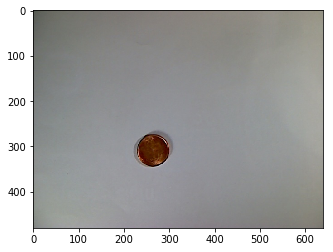

In [66]:
import cv2 
import numpy as np
from  matplotlib import pyplot as plt
import os 
import glob 
%matplotlib inline

img_bgr = cv2.imread("/mnt/data/projects/img_rot_tf2/coin/5_1477188582.jpg")
image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image)


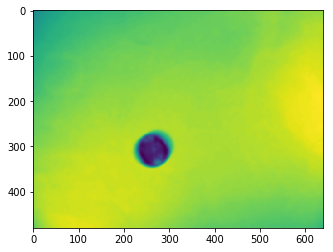

In [71]:
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray,(17,17),0)

plt.imshow(blurred)

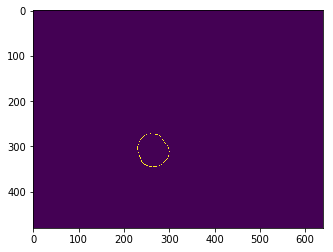

In [72]:
edged = cv2.Canny(blurred, 30, 150)
plt.imshow(edged)

In [73]:
# Note that only return two variables
(cnts,_) = cv2.findContours(edged.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
print(" {} coins in the image".format(len(cnts)))


 1 coins in the image


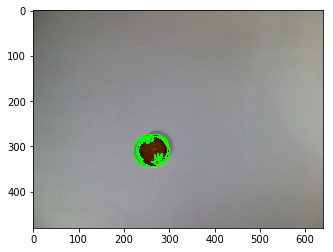

In [22]:
coins = image.copy()
cv2.drawContours(coins, cnts, -1, (0,255,0), 2)
plt.imshow(coins)

coin #1
coin #2
coin #3
coin #4
coin #5
coin #6
coin #7
coin #8
coin #9


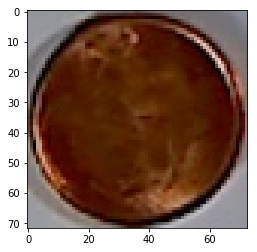

In [23]:
coins = image.copy()
cv2.drawContours(coins, cnts, -1, (0,255,0), 2)
plt.imshow(coins)

for (i,circle) in enumerate(cnts):
    # Circle is extracted from each round
    (x,y,w,h) = cv2.boundingRect(circle)
    print("coin #{}".format(i+1))
    coin_canvas = image[y:y+h, x:x+w]
    plt.imshow(coin_canvas)
    im_bgr = cv2.cvtColor(coin_canvas, cv2.COLOR_RGB2BGR)
    cv2.imwrite('coin.jpg',im_bgr)


## Function for croping the coin

In [105]:
def crop_coin(image):
    img_bgr = cv2.imread(image)
    image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray,(11,11),0)

    edged = cv2.Canny(blurred, 30, 150)
    #plt.imshow(edged)

    # Note that only return two variables
    (cnts,_) = cv2.findContours(edged.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)


    coins = image.copy()
    cv2.drawContours(coins, cnts, -1, (0,255,0), 2)
    #plt.imshow(coins)

    coins = image.copy()
    cv2.drawContours(coins, cnts, -1, (0,255,0), 2)
    #plt.imshow(coins)
    global crop

    for (i,circle) in enumerate(cnts):
        # Circle is extracted from each round
        (x,y,w,h) = cv2.boundingRect(circle)
        #print("coin #{}".format(i+1))
        crop = image[y:y+h, x:x+w]
        crop = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
    return crop

### Croping all images

In [107]:
for file in glob.glob("/mnt/data/projects/img_rot_tf2/coin/*.jpg"):
    split = os.path.split(file)
    name = str(split[-1])
    coin = crop_coin(file)
    
    if not os.path.exists(split[0]+'/crop_coins/'):
        os.makedirs(split[0]+'/crop_coins/')
        
    img = split[0]+'/crop_coins/'+name
    h,w,c = coin.shape
    if h>65 and w>65:
        # resizing croped image to 85x85
        coin = cv2.resize(coin, (85, 85),interpolation = cv2.INTER_NEAREST)
        cv2.imwrite(img,coin)
    

# Training 

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

%matplotlib inline

In [109]:
input_path = Path(split[0]+'/crop_coins/')


In [110]:
image_files = list(input_path.glob('*.jpg'))

In [111]:
def read_file(fname):
    # Read image
    im = Image.open(fname)

    # Convert to numpy array
    im_array = np.asarray(im)

    # Get target
    target = int(fname.stem.split('_')[0])

    return im_array, target

In [112]:
images = []
targets = []

for image_file in tqdm_notebook(image_files):
    image, target = read_file(image_file)
    
    images.append(image)
    targets.append(target)

/mnt/data/projects/facenet/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2178 [00:00<?, ?it/s]

In [113]:
X = (np.array(images).astype(np.float32) / 127.5) - 1
y_cls = np.array(targets)

In [114]:
X.shape, y_cls.shape

((2178, 85, 85, 3), (2178,))

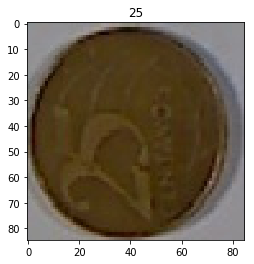

In [117]:
i = 42
plt.imshow(np.uint8((X[i] + 1) * 127.5))
plt.title(str(y_cls[i]));

In [118]:
coins_ids = {
    5: 0,
    10: 1,
    25: 2,
    50: 3,
    100: 4
}

ids_coins = [5, 10, 25, 50, 100]

y = np.array([coins_ids[coin] for coin in y_cls])

In [119]:
X_train, X_valid, y_train, y_valid, fname_train, fname_valid = train_test_split(
    X, y, image_files, test_size=0.2, random_state=42)

In [120]:
im_width = X.shape[2]
im_height = X.shape[1]

im_width, im_height

(85, 85)

### Keras

In [141]:
from keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [122]:
model = Sequential()

# CNN network
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(im_height, im_width, 3)) )
model.add( MaxPool2D(2) )

model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(128, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(256, 3, activation='relu', padding='same') )

# Transition between CNN and MLP
model.add( GlobalAvgPool2D() )

# MLP network
model.add( Dense(256, activation='relu') )

model.add( Dense(5, activation='softmax') )

model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 85, 85, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)  

In [123]:
optim = Adam(lr=1e-3)
model.compile(optim, 'sparse_categorical_crossentropy', metrics=['acc'])

In [124]:
callbacks = [
    ReduceLROnPlateau(patience=5, factor=0.1, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=12)
]

history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_valid, y_valid), batch_size=32,
                   callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1742 samples, validate on 436 samples
Epoch 1/2000
1742/1742 [==============================] - 9s 5ms/step - loss: 1.3521 - acc: 0.3829 - val_loss: 0.9401 - val_acc: 0.5849
Epoch 2/2000
1742/1742 [==============================] - 8s 5ms/step - loss: 0.8874 - acc: 0.6550 - val_loss: 0.6191 - val_acc: 0.7798
Epoch 3/2000
1742/1742 [==============================] - 8s 4ms/step - loss: 0.5742 - acc: 0.8025 - val_loss: 0.5080 - val_acc: 0.8165
Epoch 4/2000
1742/1742 [==============================] - 8s 5ms/step - loss: 0.4893 - acc: 0.8330 - val_loss: 0.4102 - val_acc: 0.8509
Epoch 5/2000
1742/1742 [==============================] - 8s 5ms/step - loss: 0.4345 - acc: 0.8439 - val_loss: 0.3237 - val_acc: 0.8807
Epoch 6/2000
1742/1742 [==============================] - 8s 5ms/step - loss: 0.4017 - acc: 0.8576 - val_loss: 0.3700 - val_acc: 0.8372
Epoch 7/2000
1742/1742 [==================

In [125]:
df_history = pd.DataFrame(history.history)

## Test Accuracy

In [127]:
df_history['val_acc'].max()

0.9793577981651376

In [128]:
model.load_weights('best.model')

In [129]:
model.evaluate(X_valid, y_valid)

436/436 [==============================] - 1s 1ms/step


[0.07112494169161954, 0.9747706422018348]

## Evaluate

In [130]:
y_pred = model.predict(X_valid)

In [131]:
y_pred_cls = y_pred.argmax(1)

In [132]:
errors = np.where(y_pred_cls != y_valid)[0]
errors

array([  0,  36,  37,  52,  58, 143, 184, 190, 306, 336, 376])

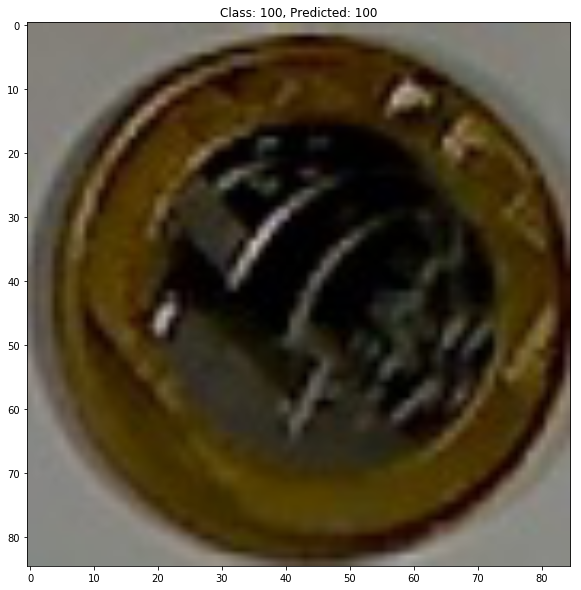

In [149]:
i = 7
plt.figure(figsize=(10, 10))
im = Image.open(fname_valid[i])
plt.imshow(np.uint8(im), interpolation='bilinear')
plt.title('Class: {}, Predicted: {}'.format(ids_coins[y_valid[i]], ids_coins[np.argmax(y_pred[i])]));

## Confusion Matrix

In [139]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[106   0   1   0   0]
 [  0  22   2   0   0]
 [  0   3 108   0   0]
 [  4   0   1  88   0]
 [  0   0   0   0 101]]


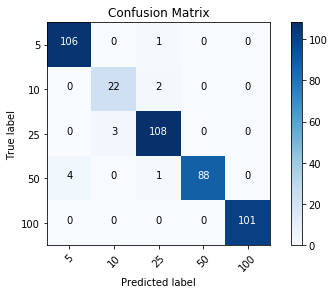

In [142]:
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_cls)
cm_plot_labels = ['5','10','25','50','100']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')